In [1]:
import os
import sys
import math
import logging
import structlog
from pathlib import Path
import json
import re
from itertools import product, combinations

import tomli
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (12, 6.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

In [2]:
logging.basicConfig(level=logging.WARNING, stream=sys.stdout)

In [3]:
import pytanis
from pytanis import GSheetClient, PretalxClient
from pytanis.google import Scope, gsheet_rows_for_fmt, worksheet_range
from pytanis.review import read_assignment_as_df, save_assignments_as_json, Col
from pytanis.pretalx import subs_as_df, reviews_as_df, speakers_as_df
from pytanis.utils import implode
from pytanis.highs import set_solution_from_file, read_sol_file

In [4]:
# Be aware that this notebook might only run with the following version
pytanis.__version__ 

'0.4'

In [5]:
# Import event-specific settings to don't have them here in the notebook
with open('config.toml', 'rb') as fh:
    cfg = tomli.load(fh)


## Gather all Data, i.e. Submissions, Votes and Scheduling Data

In [6]:
pretalx_client = PretalxClient(blocking=True)
talks_count, talks = pretalx_client.submissions(cfg['event_name'], params={"questions": "all", "state": ["confirmed"]})
talks = list(talks)
rooms_count, rooms = pretalx_client.rooms(cfg['event_name'])
rooms = list(rooms)

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
talks_df = subs_as_df(talks, with_questions=True)
# Ignore Keynotes when scheduling
talks_df = talks_df.loc[~(talks_df[Col.submission_type] == "Keynote")]
# Split track up in main/sub track
talks_df.insert(2, 'Main track', talks_df[Col.track].map(lambda x: x.split(":")[0] if not pd.isna(x) else x))
talks_df[Col.track] = talks_df[Col.track].map(lambda x: x.split(":")[-1] if not pd.isna(x) else x).map(lambda x: re.sub('[\W_]+', '', x))

In [9]:
main_tracks = [mt for mt in talks_df["Main track"].unique() if mt != 'Plenary']
sub_tracks = [st for st in talks_df[Col.track].unique() if st != 'Plenary']
print("Main tracks", main_tracks)
print("Sub tracks", sub_tracks)

Main tracks ['PyData', 'PyCon', 'General']
Sub tracks ['DataHandling', 'MachineLearningStats', 'ProgrammingSoftwareEngineering', 'Testing', 'PyDataScientificLibrariesStack', 'Jupyter', 'Web', 'PythonPyDataFriends', 'DevOpsMLOps', 'Django', 'EthicsPrivacy', 'NaturalLanguageProcessing', 'Visualisation', 'Others', 'PythonLanguage', 'Libraries', 'ComputerVision', 'DeepLearning', 'InfrastructureHardwareCloud', 'CommunityDiversityCareerLifeandeverythingelse']


In [10]:
talk2main_track = pd.concat([talks_df[Col.submission], pd.get_dummies(talks_df["Main track"]).drop(columns="Plenary")], axis=1)
talk2main_track.head()

,Submission,General,PyCon,PyData
0,S79HEH,0,0,1
1,HNKMMP,0,0,1
2,VBP3PE,0,1,0
3,AQAJDH,0,1,0
4,G9TATQ,0,0,1


In [11]:
talk2main_track = talk2main_track.melt(id_vars=Col.submission, value_vars=talk2main_track.columns, var_name='Main track').sort_values([Col.submission, "Main track"]).set_index([Col.submission, "Main track"]).to_dict()['value']

In [12]:
talk2sub_track = pd.concat([talks_df[Col.submission], pd.get_dummies(talks_df["Track"]).drop(columns="Plenary")], axis=1)
talk2sub_track.head()

,Submission,CommunityDiversityCareerLifeandeverythingelse,ComputerVision,DataHandling,DeepLearning,DevOpsMLOps,Django,EthicsPrivacy,InfrastructureHardwareCloud,Jupyter,Libraries,MachineLearningStats,NaturalLanguageProcessing,Others,ProgrammingSoftwareEngineering,PyDataScientificLibrariesStack,PythonLanguage,PythonPyDataFriends,Testing,Visualisation,Web
0,S79HEH,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HNKMMP,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,VBP3PE,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,AQAJDH,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,G9TATQ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [13]:
talk2sub_track = talk2sub_track.melt(id_vars=Col.submission, value_vars=talk2sub_track.columns, var_name='Track').sort_values([Col.submission, "Track"]).set_index([Col.submission, "Track"]).to_dict()['value']

In [14]:
talk2idx = {v: k for k, v in enumerate(set(talks_df[Col.submission].to_list()))}
idx2talk = {v: k for k, v in talk2idx.items()}

In [15]:
votes_df = pd.read_csv("./pyconde-pydata-berlin-2023-public-votes.csv")
votes_df = votes_df.rename(columns={'code': Col.submission, 'score': Col.vote_score})
# Remove votes for submissions that wheren't accepted
votes_df = votes_df.loc[votes_df[Col.submission].apply(lambda talk: talk in talk2idx.keys())].reset_index(drop=True)
# Remove votes equal 1 as this meant "being indifferent"
votes_df = votes_df.loc[votes_df[Col.vote_score] > 1]
# Move a score of 2 to 1, so that "must see" counts tripple compared to "want to see"
votes_df.loc[votes_df[Col.vote_score] == 2, Col.vote_score] = 1

In [16]:
talk_lengths = {s:d for _, (s, d) in talks_df[[Col.submission, Col.duration]].iterrows()}
print(talk_lengths)
# following tutorials build sequences and thus need to be in the same session and after one another
consecutive_tutorials = [("VFZ3VT", "DEQM3J"), ("KUKU9Z", "YWTRSG")]
sponsored_talks = [t.code for t in talks if "Sponsor" in t.submission_type.en]

{'S79HEH': 30, 'HNKMMP': 30, 'VBP3PE': 45, 'AQAJDH': 30, 'G9TATQ': 30, 'WHACAT': 30, 'GYEZVW': 30, 'V9HBUU': 90, 'MTXCHH': 30, 'E77G9H': 30, 'KUKU9Z': 90, '9SENVW': 30, 'RDQH3W': 45, 'QLCNN9': 30, '8CVQDW': 30, 'KYLLZA': 30, 'MTRFT3': 30, 'DECAHT': 45, 'CBHYXG': 30, 'UECWHD': 30, 'J9KRKZ': 30, '7FTL7H': 30, 'DXMXZH': 30, 'TP7ABB': 30, 'NUF87W': 30, 'B7PCUR': 30, 'MLAGKM': 30, 'FVWF7R': 45, 'UQ3KXD': 90, 'LXBGZS': 45, 'PPXA79': 30, 'Z8PESY': 30, 'W9HLK3': 45, 'WAVRYZ': 45, 'U7WAQW': 30, 'S8GYFF': 90, 'AXMS87': 30, 'EAKYPL': 90, 'CTKC7B': 30, 'ZYB38R': 90, 'WLMDZ7': 30, 'LCCGTT': 30, 'PQZR3Q': 90, 'SVXFP8': 30, 'TCWCVV': 45, 'NWSLUH': 30, 'SJCEFG': 30, 'YTHXML': 30, 'M7XMFB': 90, '3TH9UC': 30, 'GXPWJ8': 30, 'RPMMKZ': 90, 'ENQBPJ': 30, 'JY3R3Z': 30, 'XDRNQC': 45, 'Y9TAMP': 30, 'RQ3MWN': 30, 'FZY9VV': 90, 'WMAXSV': 45, 'HMGCPL': 45, 'GCPNMT': 30, 'H8KMTT': 30, 'ZRAFKA': 30, '8VYHKG': 30, 'TWPBZF': 30, 'GXAKV8': 45, 'MBZJE9': 30, 'NFYQHB': 30, 'HLMGHX': 30, 'NLFFSE': 30, '7SYVML': 30, 'AKXX

In [17]:
pops_dict = votes_df.groupby(Col.submission)['Vote Score'].sum().to_dict()
# give sponsored talks the median popularity
for talk in set(talks_df[Col.submission].to_list()) - set(pops_dict.keys()):
    pops_dict[talk] = np.median(list(pops_dict.values()))
# normalize the popularities
min_pop = np.min(list(pops_dict.values()))
max_pop = np.max(list(pops_dict.values()))
pops_dict = {k:(v - min_pop) / (max_pop - min_pop) for k, v in pops_dict.items()}
print({k: f"{v:.3}" for k, v in pops_dict.items()})

{'3TH9UC': '0.204', '77MWVW': '0.0741', '7EUPC3': '0.241', '7FTL7H': '0.37', '7NW7JC': '0.0556', '7SYVML': '0.167', '8CVQDW': '0.556', '8VYHKG': '0.0741', '9Q38VT': '0.222', '9SENVW': '0.333', 'A7B8P8': '0.278', 'AKXXQD': '0.315', 'AQAJDH': '0.296', 'AUJYP7': '0.167', 'AXMS87': '0.037', 'B7PCUR': '0.111', 'B8FKHC': '0.407', 'CBHYXG': '0.352', 'CHLT3D': '0.241', 'CTKC7B': '0.037', 'DB3KC7': '1.0', 'DECAHT': '0.241', 'DXMXZH': '0.296', 'E77G9H': '0.185', 'EAKYPL': '0.148', 'ENQBPJ': '0.278', 'FVWF7R': '0.185', 'FZY9VV': '0.389', 'G9TATQ': '0.204', 'GBYWCY': '0.852', 'GCPNMT': '0.296', 'GLQH8X': '0.0741', 'GXAKV8': '0.407', 'GXPWJ8': '0.0926', 'GYEZVW': '0.333', 'H7ZCWK': '0.444', 'H8KMTT': '0.204', 'HLMGHX': '0.167', 'HMGCPL': '0.037', 'HNKMMP': '0.296', 'J9KRKZ': '0.796', 'JY3R3Z': '0.222', 'KUKU9Z': '0.5', 'KYLLZA': '0.0556', 'LCCGTT': '0.556', 'LMGF8V': '0.722', 'LXBGZS': '0.315', 'M7XMFB': '0.333', 'MBZJE9': '0.574', 'MJRFLC': '0.0741', 'MLAGKM': '0.333', 'MQHTHY': '0.37', 'MTRFT3': 

In [18]:
room_caps_dict = {room.name.en.replace('-', ''):room.capacity for room in rooms}
print(room_caps_dict)
# normalize room_caps like popularity by dividing by min
min_room_cap = np.min(list(room_caps_dict.values()))
max_room_cap = np.max(list(room_caps_dict.values()))
room_caps_dict = {k: (v - min_room_cap) / (max_room_cap - min_room_cap) for k, v in room_caps_dict.items()}
tutorial_rooms =  {'A03A04', 'A05A06'}
talk_rooms = set(room_caps_dict.keys()) - tutorial_rooms
print(room_caps_dict)

{'Kuppelsaal': 950, 'B09': 240, 'B07B08': 200, 'B05B06': 300, 'A1': 80, 'A03A04': 140, 'A05A06': 140}
{'Kuppelsaal': 1.0, 'B09': 0.1839080459770115, 'B07B08': 0.13793103448275862, 'B05B06': 0.25287356321839083, 'A1': 0.0, 'A03A04': 0.06896551724137931, 'A05A06': 0.06896551724137931}


In [19]:
# generate penalty for a talk given its popularity in a certain room
talk_room_penalty = {(talk, room): (pop - cap)**2 for (talk, pop), (room, cap) in product(pops_dict.items(), room_caps_dict.items())} 
min(talk_room_penalty.values()), max(talk_room_penalty.values())

(0.0, 1.0)

In [20]:
# generate cooccurrence penalty for all talks scheduled at the same time-slot & room using Gram-matrix
n_users = votes_df['voter'].nunique()
n_talks = len(talks_df)

def user_interaction(user_votes):
    x = np.zeros(n_talks)
    for _, (sub, vote_score) in user_votes[[Col.submission, Col.vote_score]].iterrows():
        x[talk2idx[sub]] = vote_score
    return x

X = np.vstack(votes_df.groupby("voter").apply(user_interaction))
assert X.shape == (n_users, n_talks)

cooccurance_penalty = X.T @ X

# set diagonal to 0 since a talk is always parallel to itself.
np.fill_diagonal(cooccurance_penalty, 0.)

# normalize with max as sponsored talks will get the value 1.
cooccurance_penalty /= cooccurance_penalty.max() 

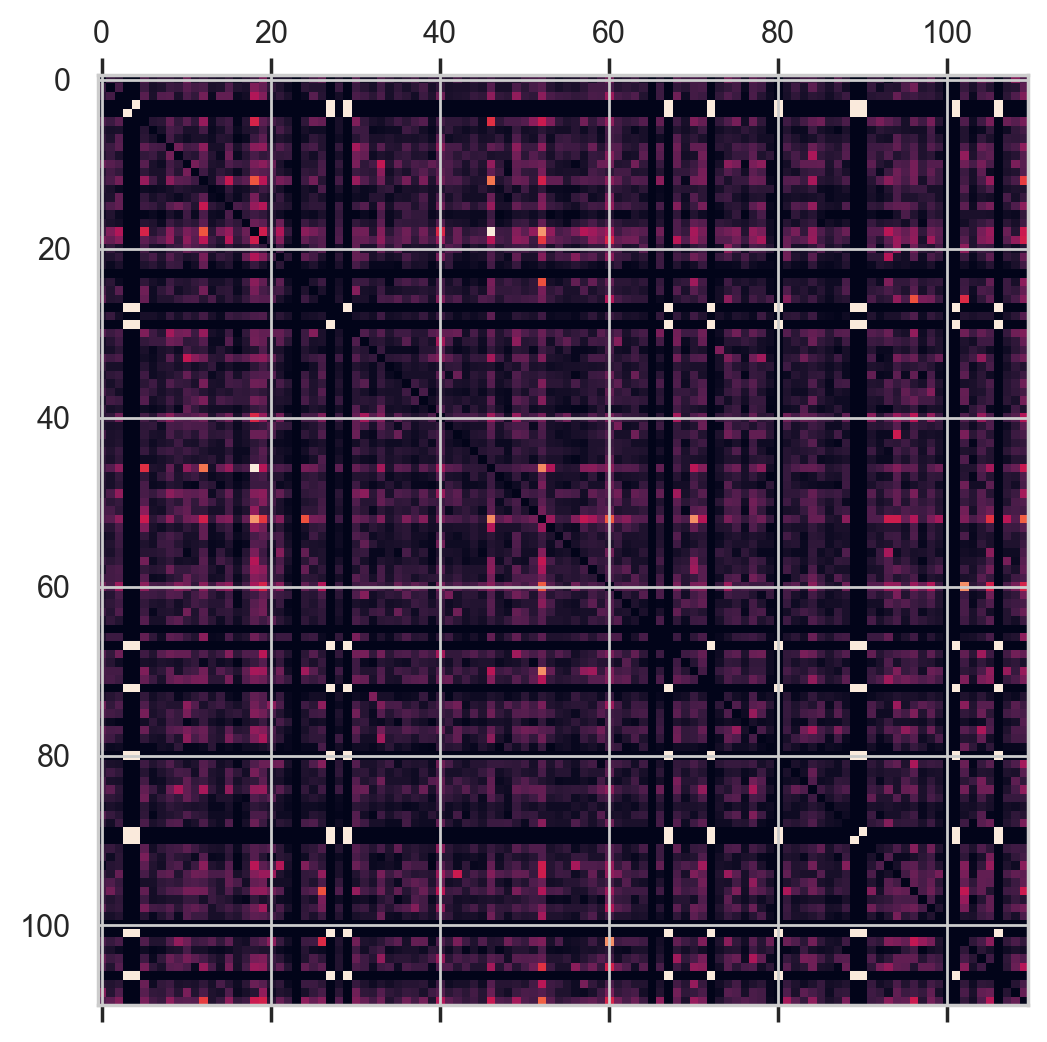

In [21]:
# for sponsored talks set a high cooccurence penalty
for t1, t2 in combinations(sponsored_talks, 2):
    cooccurance_penalty[talk2idx[t1], talk2idx[t2]] = cooccurance_penalty[talk2idx[t2], talk2idx[t1]] = 1.
    
# set diagonal to 0 since a talk is always parallel to itself.
np.fill_diagonal(cooccurance_penalty, 0.)

talk_cooccurence_penalty = {(t1, t2): cooccurance_penalty[talk2idx[t1], talk2idx[t2]]**2 for t1, t2 in product(talk2idx.keys(), talk2idx.keys())}
plt.matshow(cooccurance_penalty);

## Time-Table Scheduling

We consider following constraints:
* each talk must be assigned once
* each room/timeslot combination can only be occupied by one talk at most
* the length of the timeslot must match the length of the talk
* some tutorials have part 1 & 2,thus need to be consecutive

We optimize an objective which considers:
1. the preferences for day and time of the speakers are considered (if they provided some)
2. the more popular a talk is, the more capacity the assigned room should have
3. if many people are interested in seeing two talks (data from the votes) these talks should rather not be scheduled in parallel (sponsored talks should never be in parallel)
4. if possible have in the same session (block of talks) the same main track, e.g. PyData, 
5. or even the same sub track, e.g.PyData: Data Handling, assuming that people have certain preferences regarding tracks.

The importance is 1 > 2 > 3 > 4 > 5

In [22]:
import pyomo.environ as pyo
import pyomo.gdp as pyogdp
from pyomo.contrib.appsi.solvers import Highs
from tqdm.auto import tqdm

In [23]:
model = pyo.ConcreteModel(name="PyConDE/PyData Schedule 2023")

##############
# Index Sets #
##############

model.sTalks = pyo.Set(initialize=talks_df[Col.submission].values, ordered=True)
model.sDays = pyo.Set(initialize=["Monday", "Tuesday", "Wednesday"], ordered=True)
model.sSessions = pyo.Set(initialize=["Morning1", "Morning2", "Afternoon1", "Afternoon2"], ordered=True)
model.sSlots = pyo.Set(initialize=["First", "Second", "Third"], ordered=True)
model.sRooms = pyo.Set(initialize=room_caps_dict.keys(), ordered=True)
model.sMainTracks = pyo.Set(initialize=main_tracks, ordered=True)
model.sSubTracks = pyo.Set(initialize=sub_tracks, ordered=True)

##############
# Parameters #
##############

def init_slot_preference(model, t, d, s, l, r):
    if t in {"WHACAT", "MYARJG", "E77G9H", "8WXSR9", "TP7ABB"} and d == "Monday":
        return 1
    elif t in {"VBP3PE"} and d == "Monday" and s.startswith("Morning"):
        return 1
    elif t in {"KYLLZA", "TGZFSF"} and d == "Tuesday":
        return 1
    elif t in {"9Q38VT"} and d in {"Monday", "Tuesday"}:
        return 1
    elif t in {"GBYWCY"} and d == "Tuesday" and s.startswith("Morning"):
        return 1
    else:
        return 0

model.pPreferences = pyo.Param(model.sTalks, model.sDays, model.sSessions, model.sSlots, model.sRooms, initialize=init_slot_preference, mutable=False)
model.pTalkRoomPenalty = pyo.Param(model.sTalks, model.sRooms, initialize=talk_room_penalty, mutable=False)
model.pCoOccurencesPenalty = pyo.Param(model.sTalks, model.sTalks, initialize=talk_cooccurence_penalty, mutable=False)
model.pTalk2MainTrack = pyo.Param(model.sTalks, model.sMainTracks, initialize=talk2main_track, mutable=False)
model.pTalk2SubTrack = pyo.Param(model.sTalks, model.sSubTracks, initialize=talk2sub_track, mutable=False)

def init_slot_length(model, d, s, l, r):
    if d == "Monday":
        if s == "Morning1":
            if r in talk_rooms:
                if l in {"First", "Second"}:
                    return 45
                else:
                    return 0 # no Third slot
            else:
                return 90 if l == "First" else 0
        elif s == "Morning2" or s == "Afternoon1":
            return 0 # does not exist
        else: # "Afternoon 2":
            if r in talk_rooms:
                if r == "Kuppelsaal":
                    return 0
                elif l in {"First", "Second"}:
                    return 30
                else:
                    return 0 # no Third slot
            elif r == 'A03A04':
                if l == "First":
                    return 30
                elif l == "Second":
                    return 45
                else:
                    return 0
            else:
                return 90 if l == "First" else 0
    elif d == "Tuesday":
        if s == "Morning1" or s == "Afternoon2":
            if r in talk_rooms:
                return 30
            else:
                return 90 if l == "First" else 0
        elif s == "Afternoon1":
            if r in talk_rooms:
                if l == "First":
                    return 30
                elif l == "Second":
                    return 45
                else:
                    return 0 # no Third slot
            else:
                return 90 if l == "First" else 0
        else: # Morning 2
            return 0
    else: # Wednesday
        if s == "Morning1":
            if r in talk_rooms:
                if l == "First":
                    return 45
                elif l == "Second":
                    return 30
                else:
                    return 0 # no Third slot
            else:
                return 90 if l == "First" else 0
        elif s == "Morning2":
            if r in talk_rooms:
                if l in {"First", "Second"}:
                    return 30
                else:
                    return 0 # no Third slot
            else:
                return 90 if l == "First" else 0
        elif s == "Afternoon1":
            if r in talk_rooms:
                return 30
            else:
                return 90 if l == "First" else 0
        else: # Afternoon 2
            return 0
    raise RuntimeError(f"Unhandled case {d}, {s}, {l}, {r}")
    
model.pSlotLengths = pyo.Param(model.sDays, model.sSessions, model.sSlots, model.sRooms, initialize=init_slot_length, mutable=False)
model.pTalkLengths = pyo.Param(model.sTalks, initialize=talk_lengths, mutable=False)

#############
# Variables #
#############

## Auxiliary variables
# indicator if talk t is in room r
model.vbTalkRoom = pyo.Var(model.sTalks, model.sRooms, domain=pyo.Binary) 
# indicator if talk t is in day/session/slot combination. Used later to calculate cooccurences.
model.vbParallelTalk = pyo.Var(model.sTalks, model.sDays, model.sSessions, model.sSlots, domain=pyo.Binary) 
# indicator if two talks are in the same day/session/slot combination, thus are running in parallel and only one can be attended to.
model.vbCoOccurences = pyo.Var(model.sTalks, model.sTalks, model.sDays, model.sSessions, model.sSlots, domain=pyo.Binary) 
# indicator if main track occures in day/session/room combination, i.e. occurs in the current session of a room
model.vbMainTrackSessionRoom = pyo.Var(model.sDays, model.sSessions, model.sRooms, model.sMainTracks, domain=pyo.Binary) 
# indicator if sub track occures in day/session/room combination, i.e. occurs in the current session of a room
model.vbSubTrackSessionRoom = pyo.Var(model.sDays, model.sSessions, model.sRooms, model.sSubTracks, domain=pyo.Binary)
# indicator if talk t is in day/session/room combination, i.e. talk is in a session of a room.
model.vbTalkSession = pyo.Var(model.sTalks, model.sDays, model.sSessions, model.sRooms, domain=pyo.Binary)

## Decision variable
model.vbSchedule = pyo.Var(model.sTalks, model.sDays, model.sSessions, model.sSlots, model.sRooms, domain=pyo.Binary)

###############
# Constraints #
###############

# Make sure talk lengths fits slot lengths
model.ctTalkSlotFit = pyo.ConstraintList()
for t in model.sTalks:
    model.ctTalkSlotFit.add(sum(model.vbSchedule[t, d, s, l, r] * model.pSlotLengths[d, s, l, r] for d, s, l, r in product(model.sDays, model.sSessions, model.sSlots, model.sRooms)) == model.pTalkLengths[t])
    
# Make sure each room/timeslot-combination is occupied only with one talk at most
model.ctTimeRoomOccup = pyo.ConstraintList()
for d, s, l, r in product(model.sDays, model.sSessions, model.sSlots,  model.sRooms):
    model.ctTimeRoomOccup.add(sum(model.vbSchedule[:, d, s, l, r]) <= 1)
    
# Set vbParallelTalk auxiliary variable
model.ctParallelTalk = pyo.ConstraintList()
for t, d, s, l in product(model.sTalks, model.sDays, model.sSessions, model.sSlots):
    model.ctParallelTalk.add(model.vbParallelTalk[t, d, s, l] == sum(model.vbSchedule[t, d, s, l, :]))
                               
# Make sure each talk is assigned once
model.ctTalkAssigned = pyo.ConstraintList()
for t in model.sTalks:
    model.ctTalkAssigned.add(sum(model.vbSchedule[t, :, :, :, :]) == 1)

# Set vbCoOccurences auxiliary variable    
model.ctCoOccurences = pyo.ConstraintList()
for d, s, l in product(model.sDays, model.sSessions, model.sSlots):
    for t1, t2 in combinations(model.sTalks, 2):
        model.ctCoOccurences.add(model.vbCoOccurences[t1, t2, d, s, l] + 1 >= model.vbParallelTalk[t1, d, s, l] + model.vbParallelTalk[t2, d, s, l])

# Set vbTalkRoom auxiliary variable
model.ctTalkRoom = pyo.ConstraintList()
for t, r in product(model.sTalks, model.sRooms):
    model.ctTalkRoom.add(sum(model.vbSchedule[t, ..., r]) == model.vbTalkRoom[t, r])

# Enforce that some talks need to be in consecutive order
def ct_consecutive_slots(model, t1, t2):
    possibilities = [(("Tuesday", "Afternoon1", "First", r), ("Tuesday", "Afternoon2", "First", r)) for r in tutorial_rooms]
    possibilities.extend([(("Wednesday", "Morning1", "First", r), ("Wednesday", "Morning2", "First", r)) for r in tutorial_rooms])
    return [[model.vbSchedule[t1, d1, s1, l1, r1] + model.vbSchedule[t2, d2, s2, l2, r2] == 2] for (d1, s1, l1, r1), (d2, s2, l2, r2) in possibilities]

# Set disjunction constraint for consecutive tutorials
for i, (t1, t2) in enumerate(consecutive_tutorials):
    # there seems to be no List object for disjunctions, thus we use setattr
    setattr(model, f'disjTutorial{i}', pyogdp.Disjunction(expr=ct_consecutive_slots(model, t1, t2)))
    
# Set vbTalkSession auxiliary variable
model.ctTalkSession = pyo.ConstraintList()
for t, d, s, r in product(model.sTalks, model.sDays, model.sSessions, model.sRooms):
    model.ctTalkSession.add(model.vbTalkSession[t, d, s, r] == sum(model.vbSchedule[t, d, s, :, r]))
    
# Set vbMainTrackSessionRoom auxiliary variable
model.ctMainTrackSessionRoom = pyo.ConstraintList()
for d, s, r, mt in product(model.sDays, model.sSessions, model.sRooms, model.sMainTracks):
    model.ctMainTrackSessionRoom.add(model.vbMainTrackSessionRoom[d, s, r, mt]*len(model.sSlots) >= sum(model.vbTalkSession[t, d, s, r]*model.pTalk2MainTrack[t, mt] for t in model.sTalks))
    
# Set vbSubTrackSessionRoom auxiliary variable
model.ctSubTrackSessionRoom = pyo.ConstraintList()
for d, s, r, st in product(model.sDays, model.sSessions, model.sRooms, model.sSubTracks):
    model.ctSubTrackSessionRoom.add(model.vbSubTrackSessionRoom[d, s, r, st]*len(model.sSlots) >= sum(model.vbTalkSession[t, d, s, r]*model.pTalk2SubTrack[t, st] for t in model.sTalks))
    
#############
# Objective #
############# 

def objective(model):
    preference_term = pyo.dot_product(model.pPreferences, model.vbSchedule)
    pop_roomcap_term = pyo.dot_product(model.pTalkRoomPenalty, model.vbTalkRoom)
    cooccurance_terms = []
    for d, s, l in product(model.sDays, model.sSessions, model.sSlots):
        cooccurance_terms.append(sum(model.vbCoOccurences[t1, t2, d, s, l] * model.pCoOccurencesPenalty[t1, t2] for t1, t2 in combinations(model.sTalks, 2)))
    cooccurance_term = sum(cooccurance_terms) + sum(model.vbCoOccurences[...]) # last term forces vbCoOccurences to be 0 if possible
    main_tack_term = sum(model.vbMainTrackSessionRoom[...])  # the higher this number the more different tracks we have in a session. We want the opposite.
    sub_track_term = sum(model.vbSubTrackSessionRoom[...])  # see above
    
    return 100_000_000*preference_term - 1_000_000*pop_roomcap_term - 10_000*cooccurance_term - 100*main_tack_term - sub_track_term
    
model.obj = pyo.Objective(sense=pyo.maximize, rule=objective)
pyo.TransformationFactory("gdp.bigm").apply_to(model)


In [24]:
# consistency check: amount of lengths of talks/timeslots must match
print("Slots:\n", pd.Series(model.pSlotLengths.values()).value_counts(), sep='')
print("\nTalks:\n", talks_df[Col.duration].value_counts(), sep='')

Slots:
0     142
30     74
45     21
90     15
dtype: int64

Talks:
30    74
45    21
90    15
Name: Duration, dtype: int64


In [25]:
# Optionally write out the model file to solve it on the CLI directly, which provides more info while running
model.write(filename = "pyconde_pydata_schedule_20230306-final.mps", io_options = {"symbolic_solver_labels":True})

('pyconde_pydata_schedule_20230306-final.mps', 4915968416)

In [ ]:
# solve it here directly
solver = Highs()
solver.config.time_limit = 600. # 10 minutes, set to a number high enough to reach a feasible solution
solver.config.load_solution = False
sol = solver.solve(model)
solver.load_vars() # only works if solution is valid/feasible

In [ ]:
# or better in the CLI 
!highs pyconde_pydata_schedule_20230306-final.mps --solution_file 20230306-final.sol --time_limit 36000 # 10 hours!

In [211]:
set_solution_from_file(model, "20230306-final.sol")

Running HiGHS 1.5.1 [date: 2023-02-24, git hash: n/a]
Copyright (c) 2023 HiGHS under MIT licence terms


## Upload to GSheet

In [212]:
schedule_df = pd.DataFrame([idx for idx, val in model.vbSchedule.items() if val() >= 0.5], columns=[Col.submission, "Day", "Session", "Slot", "Room"])
schedule_df = schedule_df.loc[:, ["Day", "Session", "Slot", "Room", Col.submission]]
schedule_df["Day"] = pd.Categorical(schedule_df["Day"], model.sDays.data())
schedule_df["Session"] = pd.Categorical(schedule_df["Session"], model.sSessions.data())
schedule_df["Slot"] = pd.Categorical(schedule_df["Slot"], model.sSlots.data())
schedule_df["Room"] = pd.Categorical(schedule_df["Room"], model.sRooms.data())
schedule_df.sort_values(list(schedule_df.columns[:-1]), inplace=True)
schedule_df.reset_index(drop=True, inplace=True)
timetable_df = schedule_df.pivot(index=["Day", "Session", "Slot"], columns="Room", values=Col.submission)

In [213]:
timetable_df

Room                        Kuppelsaal     B09  B07B08  B05B06      A1  \
Day       Session    Slot                                                
Monday    Morning1   First      DB3KC7  DTBTVF  DECAHT  LXBGZS  XDRNQC   
                     Second     VBP3PE  WAVRYZ  3TYND7  WMAXSV  77MWVW   
          Afternoon2 First         NaN  MYARJG  E77G9H  GCPNMT  AXMS87   
                     Second        NaN  8WXSR9  WHACAT  TP7ABB  GXPWJ8   
Tuesday   Morning1   First      XEVGVJ  ABNXHC  AUJYP7  MLAGKM  NLFFSE   
                     Second     LMGF8V  U7WAQW  9Q38VT  AKXXQD  WLMDZ7   
                     Third      GBYWCY  VRGANP  SSTCTS  SJCEFG  KYLLZA   
          Afternoon1 First      TWPBZF  NWSLUH  Q9GVEK  MQHTHY  UECWHD   
                     Second     B8FKHC  KMGYZF  X89787  RDQH3W  HMGCPL   
          Afternoon2 First      NFYQHB  Y9TAMP  7SYVML  H7ZCWK  8VYHKG   
                     Second     ZRAFKA  JY3R3Z  PPXA79  9SENVW  RQ3MWN   
                     Third      8CVQDW  TGZFSF  WMWZQC  HNKMMP  MJRFLC   
Wednesday Morning1   First      GXAKV8  Q7GS8Y  TCWCVV  W9HLK3  7NW7JC   
                     Second     J9KRKZ  7EUPC3  3TH9UC  DXMXZH  SVXFP8   
          Morning2   First      LCCGTT  ENQBPJ  YTHXML  VXPFFP  QUAXG3   
                     Second     MBZJE9  33XCUR  G9TATQ  GYEZVW  CTKC7B   
          Afternoon1 First      Z8PESY  CHLT3D  HLMGHX  7FTL7H  QLCNN9   
                     Second     S79HEH  UNA9AN  H8KMTT  CBHYXG  PEQZTC   
                     Third      NUF87W  A7B8P8  MTXCHH  AQAJDH  MTRFT3   

Room                         A03A04  A05A06  
Day       Session    Slot                    
Monday    Morning1   First   S8GYFF  UQ3KXD  
                     Second     NaN     NaN  
          Afternoon2 First   B7PCUR  PQZR3Q  
                     Second  FVWF7R     NaN  
Tuesday   Morning1   First   RPMMKZ  V9HBUU  
                     Second     NaN     NaN  
                     Third      NaN     NaN  
          Afternoon1 First   VFZ3VT  FZY9VV  
                     Second     NaN     NaN  
          Afternoon2 First   DEQM3J  M7XMFB  
                     Second     NaN     NaN  
                     Third      NaN     NaN  
Wednesday Morning1   First   KUKU9Z  EAKYPL  
                     Second     NaN     NaN  
          Morning2   First   YWTRSG  ZYB38R  
                     Second     NaN     NaN  
          Afternoon1 First   XJSNBQ  GLQH8X  
                     Second     NaN     NaN  
                     Third      NaN     NaN

In [214]:
def cell_content(sub):
    talks_df_idx = talks_df.set_index(Col.submission)
    main_track = talks_df_idx.loc[sub, "Main track"]
    sub_track = talks_df_idx.loc[sub, "Track"]
    sub_track_max = 20
    sub_track = sub_track if len(sub_track) < sub_track_max else sub_track[:sub_track_max-3] + "..."
    sponsored = "\nSponsored" if sub in sponsored_talks else ""
    content = f"{sub2title[sub]}\n{main_track}: {sub_track}\n{talk_lengths[sub]}min\nPop: {pops_dict[sub]:.0%}{sponsored}"
    return f'=HYPERLINK("https://pretalx.com/orga/event/{cfg["event_name"]}/submissions/{sub}", "{content}")'

# make submission code a hyperlink
sub2title = {t.code: t.title.replace('"', "'") for t in talks}
schedule_df[Col.submission] = schedule_df[Col.submission].map(cell_content)
schedule_df["Room"] = schedule_df["Room"].map(lambda room: f"{room} Cap: {room_caps_dict[room]:.0%}")
timetable_df = schedule_df.pivot(index=["Day", "Session", "Slot"], columns="Room", values=Col.submission)

In [215]:
gsheet_client = GSheetClient(read_only=False)

In [216]:
gsheet_client.save_df_as_gsheet(timetable_df.reset_index(), cfg['schedule_spread_id'], cfg['schedule_work_name'])

In [217]:
from gspread_formatting import set_column_width, set_row_height, cellFormat, format_cell_range

worksheet = gsheet_client.gsheet(cfg['schedule_spread_id'], cfg['schedule_work_name'])
set_column_width(worksheet, 'D:J', 200)
set_row_height(worksheet, f"2:{len(timetable_df)+1}", 130)

fmt = cellFormat(wrapStrategy='WRAP')
format_cell_range(worksheet, worksheet_range(worksheet), fmt)

{'spreadsheetId': '1_ZZ6ybY2M6U5pfR34OyKgCmadWE5sX1eTVp2B_DLqmA',
 'replies': [{}]}

## References
* https://fran-espiga.medium.com/mixed-integer-programming-for-time-table-scheduling-eee326deda75
* https://towardsdatascience.com/schedule-optimisation-using-linear-programming-in-python-9b3e1bc241e1
* https://math.stackexchange.com/questions/432003/converting-absolute-value-program-into-linear-program